In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

# Image Preparation

In [2]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
path_train = 'SaltID/train/'
path_test = 'SaltID/test/'

In [3]:
train_path_images = os.path.abspath("SaltID/train/images")
train_path_masks = os.path.abspath("SaltID/train/masks")

test_path_images = os.path.abspath("SaltID/test/images")
test_path_masks = os.path.abspath("SaltID/test/masks")

In [4]:
train_path_images_list = glob(os.path.join(train_path_images, "**/*.png"))
train_path_masks_list = glob(os.path.join(train_path_masks, "**/*.png"))
test_path_images_list = glob(os.path.join(test_path_images, "**/*.png"))
test_path_masks_list = glob(os.path.join(test_path_masks, "**/*.png"))

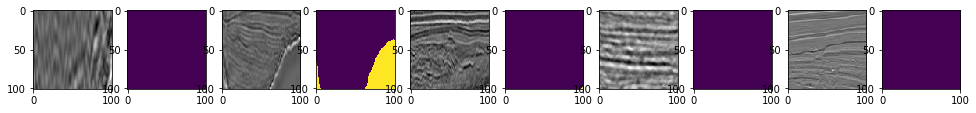

In [5]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = imread('SaltID/train/images/' + img_name + '.png')
    img_mask = imread('SaltID/train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [6]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [7]:
depths = pd.read_csv("SaltID/depths.csv")
print(depths['z'].min(), depths['z'].max())

50 959


In [8]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool_)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    img = imread(path_train + '/images/' + id_)
    x = resize(img, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = imread(path_train + '/masks/' + id_)
    Y_train[n] = resize(mask, (128, 128, 1), 
                        mode='constant', 
                        anti_aliasing=True,
                        preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 


C:\Users\e.istre91\Anaconda3\envs\pyt-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


In [9]:
# # Get and resize train images and masks
# X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
# print('Getting and resizing test images and masks ... ')
# sys.stdout.flush()
# for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
#     img = imread(path_test + '/images/' + id_)
#     x = resize(img, (128, 128, 1), mode='constant', preserve_range=True)
#     X_test[n] = x

# print('Done!')

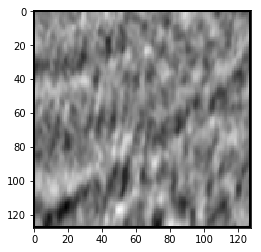

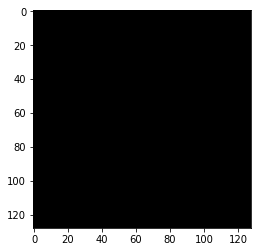

In [10]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [11]:
# # Check if training data looks all right
# ix = random.randint(0, len(test_ids))
# plt.imshow(np.dstack((X_test[ix],X_test[ix],X_test[ix])))
# plt.show()

# Prepare Images for Pytorch

In [12]:
# https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader
class saltIDDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images,train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)

In [13]:
X_train_shaped = X_train.reshape(-1, 1, 128, 128)/255
Y_train_shaped = Y_train.reshape(-1, 1, 128, 128)

In [14]:
X_train_shaped = X_train_shaped.astype(np.float32)
Y_train_shaped = Y_train_shaped.astype(np.float32)

#X_test_shaped = X_test.astype(np.float32)

In [15]:
torch.cuda.manual_seed_all(4200)
np.random.seed(133700)

In [16]:
indices = list(range(len(X_train_shaped)))
np.random.shuffle(indices)

val_size = 1/10
split = np.int_(np.floor(val_size * len(X_train_shaped)))

train_idxs = indices[split:]
val_idxs = indices[:split]

In [17]:
salt_ID_dataset_train = saltIDDataset(X_train_shaped[train_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped)
salt_ID_dataset_val = saltIDDataset(X_train_shaped[val_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped)
#salt_ID_dataset_test = saltIDDataset(X_test_shaped, train=False)

batch_size = 32
n_iters = 8000
num_epochs = n_iters / (len(X_train_shaped) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)

# test_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_test, 
#                                           batch_size=batch_size, 
#                                           shuffle=False)

In [18]:
num_epochs

64

# Define U-Net Model

In [31]:
def conv_relu(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size,
                          stride, padding),
                nn.ReLU())

class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True))
        
    def forward(self, x):
        x = self.conv(x)
        return x
        
start_fm = 16

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet, self).__init__()
        
        # Input 128x128x1 (?)
        
        #Contracting Path
        
        #(Double) Convolution 1        
        self.double_conv1 = double_conv(1, start_fm, 3, 1, 1)
        #Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 2
        self.double_conv2 = double_conv(start_fm, start_fm * 2, 3, 1, 1)
        #Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 3
        self.double_conv3 = double_conv(start_fm * 2, start_fm * 4, 3, 1, 1)
        #Max Pooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 4
        self.double_conv4 = double_conv(start_fm * 4, start_fm * 8, 3, 1, 1)
        #Max Pooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 5
        self.double_conv5 = double_conv(start_fm * 8, start_fm * 16, 3, 1, 1)
        
        #Transposed Convolution 4
        self.t_conv4 = nn.ConvTranspose2d(start_fm * 16, start_fm * 8, 2, 2)
        # Expanding Path Convolution 4 
        self.ex_double_conv4 = double_conv(start_fm * 16, start_fm * 8, 3, 1, 1)
        
        #Transposed Convolution 3
        self.t_conv3 = nn.ConvTranspose2d(start_fm * 8, start_fm * 4, 2, 2)
        #Convolution 3
        self.ex_double_conv3 = double_conv(start_fm * 8, start_fm * 4, 3, 1, 1)
        
        #Transposed Convolution 2
        self.t_conv2 = nn.ConvTranspose2d(start_fm * 4, start_fm * 2, 2, 2)
        #Convolution 2
        self.ex_double_conv2 = double_conv(start_fm * 4, start_fm * 2, 3, 1, 1)
        
        #Transposed Convolution 1
        self.t_conv1 = nn.ConvTranspose2d(start_fm * 2, start_fm, 2, 2)
        #Convolution 1
        self.ex_double_conv1 = double_conv(start_fm * 2, start_fm, 3, 1, 1)
        
        # One by One Conv
        self.one_by_one = nn.Conv2d(start_fm, 1, 1, 1, 0)
        #self.final_act = nn.Sigmoid()
        
        
    def forward(self, inputs):
        # Contracting Path
        conv1 = self.double_conv1(inputs)
        maxpool1 = self.maxpool1(conv1)
        #print(conv1.size(), maxpool1.size())

        conv2 = self.double_conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)
        #print(conv2.size(), maxpool2.size())

        conv3 = self.double_conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)
        #print(conv3.size(), maxpool3.size())

        conv4 = self.double_conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)
        #print(conv4.size(), maxpool4.size())
            
        # Bottom
        conv5 = self.double_conv5(maxpool4)
        #print(conv5.size())
        
        # Expanding Path
        t_conv4 = self.t_conv4(conv5)
        cat4 = torch.cat([conv4 ,t_conv4], 1)
        #print(cat4.size())
        ex_conv4 = self.ex_double_conv4(cat4)
        #print(t_conv4.size(), ex_conv4.size())
        
        t_conv3 = self.t_conv3(ex_conv4)
        cat3 = torch.cat([conv3 ,t_conv3], 1)
        ex_conv3 = self.ex_double_conv3(cat3)
        #print(t_conv3.size(), ex_conv3.size())

        t_conv2 = self.t_conv2(ex_conv3)
        cat2 = torch.cat([conv2 ,t_conv2], 1)
        ex_conv2 = self.ex_double_conv2(cat2)
        #print(t_conv2.size(), ex_conv2.size())
        
        t_conv1 = self.t_conv1(ex_conv2)
        cat1 = torch.cat([conv1 ,t_conv1], 1)
        ex_conv1 = self.ex_double_conv1(cat1)
        #print(t_conv1.size(), ex_conv1.size())
        
        one_by_one = self.one_by_one(ex_conv1)
        #print(one_by_one.size())
        #final = self.final_act(one_by_one)
        
        #final = torch.where((final > .5).cuda(), ones, zeros)
        
        return one_by_one

In [32]:
print(torch.__version__)

0.4.1


In [33]:
model = Unet()
model.cuda();

criterion = nn.BCEWithLogitsLoss()

learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [34]:
#output_dist = []
iter = 0
for epoch in range(50):
    losses = []
    for i, (images, masks) in enumerate(train_loader):        
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)        
        #print(outputs, masks)
        
        #print(outputs.shape, masks.shape)
        loss = criterion(outputs, masks)
        losses.append(loss.data.item())
                
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()

        iter += 1

        #if iter % 100 == 0:

    # Print Loss
    t_scores=[1]
    print('Epoch: {}. Loss: {}. Mean IU: {}'.format(epoch, np.mean(losses), np.mean(t_scores)))

Epoch: 0. Loss: 0.6092444653004672. Mean IU: 1.0
Epoch: 1. Loss: 0.5707352673057962. Mean IU: 1.0
Epoch: 2. Loss: 0.5673282623818491. Mean IU: 1.0
Epoch: 3. Loss: 0.5681683014979405. Mean IU: 1.0
Epoch: 4. Loss: 0.5674586195861344. Mean IU: 1.0
Epoch: 5. Loss: 0.5680634210594987. Mean IU: 1.0
Epoch: 6. Loss: 0.5671724687635371. Mean IU: 1.0
Epoch: 7. Loss: 0.5674928801249614. Mean IU: 1.0
Epoch: 8. Loss: 0.5677711781674781. Mean IU: 1.0
Epoch: 9. Loss: 0.567305948618239. Mean IU: 1.0
Epoch: 10. Loss: 0.5671791698025391. Mean IU: 1.0
Epoch: 11. Loss: 0.5676645322711067. Mean IU: 1.0
Epoch: 12. Loss: 0.5667396733718636. Mean IU: 1.0
Epoch: 13. Loss: 0.5674412435134956. Mean IU: 1.0
Epoch: 14. Loss: 0.5672345852429888. Mean IU: 1.0
Epoch: 15. Loss: 0.5671656503614071. Mean IU: 1.0
Epoch: 16. Loss: 0.5673670022361046. Mean IU: 1.0
Epoch: 17. Loss: 0.5671204249415778. Mean IU: 1.0
Epoch: 18. Loss: 0.5671125236338219. Mean IU: 1.0
Epoch: 19. Loss: 0.5668656485798085. Mean IU: 1.0
Epoch: 20. 

KeyboardInterrupt: 

In [ ]:
#             t_scores = []
#             # Iterate through test dataset
#             for threshold in [.1]: #, .55, .6, .65, .7, .75, .8, .85, .9, .95]:
#                 true_pos = 0
#                 false_pos = 0
#                 false_neg = 0
#                 true_neg = 0
#                 #print(threshold)
#                 for val_images, val_masks in train_loader:

#                     val_images = Variable(val_images.cuda())
#                     val_masks = val_masks.cuda()

#                     val_outputs = model(val_images)
#                     #print(val_outputs, val_outputs.shape)
#                     #if np.random.rand() > .99:
#                     #    output_dist.extend(val_outputs.cpu())
                    
#                     bin_outputs = torch.where(val_outputs > .3, 
#                                               ones, 
#                                               zeros).byte()
#                     #print(bin_outputs)
#                     bin_masks = val_masks.byte()
                    
#                     for bin_output, bin_mask in zip(bin_outputs, bin_masks):
#                         #print(bin_output | bin_mask)
#                         #print(bin_output & bin_mask)
#                         union = (bin_output | bin_mask).sum()
#                         inter = (bin_output & bin_mask).sum()
#                         #if inter > 0:
#                         #    print(union, inter)
#                         if inter == 0:
#                             iou = 0
#                         else:
#                             iou = inter / union
                        
#                         #print("iou", iou)
                        
#                         mask_obj = bin_mask.any()
#                         output_obj = bin_output.any()
                        
#                         #if output_obj:
#                         #    print(bin_output)
                        
#                         if iou > threshold:
#                             true_pos += 1
#                         elif iou <= threshold and mask_obj:
#                             false_neg += 1
#                         elif iou <= threshold and output_obj:
#                             false_pos += 1
#                         elif not mask_obj and not output_obj:
#                             true_neg += 1
#                         else:
#                             print("freak out")
                
#                 print(true_pos, false_pos, false_neg, true_neg)
#                 t_score = true_pos / (true_pos + false_pos + false_neg)
                    
#                 t_scores.append(t_score)

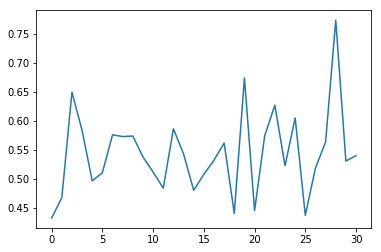

In [208]:
loss_series = pd.Series(losses)
loss_series.plot()

In [190]:
ones = torch.ones(batch_size, 1, 128, 128).cuda()
zeros = torch.zeros(batch_size, 1, 128, 128).cuda()